# Source inversion using local infrasound data
This notebook can be used to perform a Monte-Carlo Markov chain inversion of moment tensor components and focal depth of the 2020 Kiruna minequake, Sweden using local infrasound data recorded at KRIS infrasound array. 

The methodology is further described in Turquet, Brissaud et al, "Retrieving seismic source characteristics using seismic and infrasound data: The 2020 mb 4.9 Kiruna minequake, Sweden", Geophysical Research Letters, 2024

Code developed by Quentin Brissaud

In [1]:
#%matplotlib notebook
%matplotlib widget
import pandas as pd
import numpy as np
import os
import obspy
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats

## Import custom modules
import modules_data

## Load full waveform simulation data

In [2]:
simus_dir = '/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/'
options = dict(pattern='simulation_Kiruna_KRIS_Celso_inversion', remove=[], simu_cols=['dx', 'z-min', 'z-max'], parfile_cols=['DT', 'STACEY_ABSORBING_CONDITIONS', 'PML_BOUNDARY_CONDITIONS'], source_cols=['zs', 'stf', 'f0', 'Mnn', 'Mee', 'Mdd', 'mt_coord_system'], ref_station_cols=['name'])

all_simus = modules_data.read_files_patterns(simus_dir, **options)
all_simus.reset_index(drop=True, inplace=True)

Remove: []
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs0.2
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs0.5
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs0.7
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs1.0
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs1.2
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs1.5
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs2.0
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs0.2
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs0.5
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion

## Load full waveform simulation parameters 

In [3]:
starttime = UTCDateTime(2020, 5, 18, 1, 11, 56)
t0=0.
tmax=60.
geometrical_factor = np.sqrt(9200)
gaussian_to_celso_stf_factor_are = 47
celso_to_dineva_moment = 1.#7/4.25
scaling_time_integral = 1./1.3
scaling_factor = 79427686.38003613 * scaling_time_integral
scaling_factor /= (geometrical_factor*gaussian_to_celso_stf_factor_are*celso_to_dineva_moment)
freq_bands = [(0.05, 0.3), (0.2, 0.5), (0.05, 0.75)] # Nearfield plots
freq_bands = [(0.05, 0.5),] # Nearfield plots
depths = []#[-2000, -1000, -500, -200]
file_requested = 'NO.KI.BXZ.semv'
offset_SPECFEM_time_for_stf = -1.7 # to account for offset in SPECFEM simulations
alpha = 0.01
stretch_IS_and_seismic = 0.

all_simus_loc = all_simus.loc[~all_simus.index.isin(all_simus.loc[all_simus.file.str.contains('calib')].index)]
#all_simus_loc = all_simus_loc.loc[all_simus_loc.file.str.contains('0.7')]
#all_simus_loc = all_simus_loc.loc[~all_simus_loc.file.str.contains('0.5')&~all_simus_loc.file.str.contains('2.0')]

all_st, all_tr_data = [], []
all_simus_to_plot = pd.DataFrame()
for id_freq, (freqmin, freqmax) in enumerate(freq_bands):
    
    simus_to_plot, st = modules_data.get_tr_group_simus(all_simus_loc, starttime, freqmin=freqmin, freqmax=freqmax, t0=t0, tmax=tmax, f0s=[], depths=depths, scaling_factor=scaling_factor, file_specfem=file_requested, offset_SPECFEM_time_for_stf=offset_SPECFEM_time_for_stf, alpha=alpha, stretch_IS_and_seismic=stretch_IS_and_seismic)
    simus_to_plot['freq_min'] = freqmin
    simus_to_plot['freq_max'] = freqmax
    simus_to_plot['no'] = simus_to_plot['file'].str.split('_').str[-1]
    all_simus_to_plot = all_simus_to_plot.append(simus_to_plot)
    all_st.append( st.copy() )
    
    tr_data = modules_data.load_data('/staff/quentin/Documents/Projects/Kiruna/waveforms/XX.KI1.00.BDF.D.2020.139_0_60.SAC', freqmin=freqmin, freqmax=freqmax, zerophase=False)
    all_tr_data.append( tr_data.copy() )
    
all_simus_to_plot.reset_index(drop=True, inplace=True)

/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs0.2/OUTPUT_FILES/NO.KI.BXZ.semv


/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  data_IS[ind_time] = compute_3d(times[ind_time], data_IS[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  data_seismic[ind_time] = compute_3d(times[ind_time], data_seismic[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  data_IS[ind_time] = compute_3d(times[ind_time], data_IS[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  data_seismic[ind_time] = compute_3d(times[ind_time], data_seismic[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWar

/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs0.5/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs0.7/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs1.0/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs1.2/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs1.5/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxx_zs2.0/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs0.2/OUTPUT_FILES/NO.KI.BXZ.semv


/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  data_IS[ind_time] = compute_3d(times[ind_time], data_IS[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  data_seismic[ind_time] = compute_3d(times[ind_time], data_seismic[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  data_IS[ind_time] = compute_3d(times[ind_time], data_IS[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  data_seismic[ind_time] = compute_3d(times[ind_time], data_seismic[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWar

/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs0.5/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs0.7/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs1.0/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs1.2/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs1.5/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mxz_zs2.0/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mzz_zs0.2/OUTPUT_FILES/NO.KI.BXZ.semv
/staff/quentin/Documents/Codes/specfem-dg/EXAMPLES/simulation_Kiruna_KRIS_Celso_inversion_Mzz_zs0.5/OUTP

/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  data_IS[ind_time] = compute_3d(times[ind_time], data_IS[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  data_seismic[ind_time] = compute_3d(times[ind_time], data_seismic[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  data_IS[ind_time] = compute_3d(times[ind_time], data_IS[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  data_seismic[ind_time] = compute_3d(times[ind_time], data_seismic[ind_time], vel, r, alpha=alpha)
/staff/quentin/Documents/Projects/Kiruna/modules_data.py:192: ComplexWar

## MCMC inversion: data preprocessing

In [4]:
id_freq = 0
freq = 5.
l_mecha = ['Mxx', 'Mxz', 'Mzz']
l_depths = np.unique([float(tr.stats.station.split('zs')[-1]) for tr in all_st[0]])

tr = {}
starttime = all_st[id_freq][0].stats.starttime
min_endtime = all_st[id_freq][0].stats.endtime
for mecha in l_mecha:
    for depth in l_depths:
        for itr, one_tr in enumerate(all_st[id_freq]):
            if (mecha in one_tr.stats.station) and (depth == float(one_tr.stats.station.split('zs')[-1])):
                break
        if not mecha in tr:
            tr[mecha] = {}
        tr[mecha][depth] = all_st[id_freq][itr].copy()
        tr[mecha][depth].resample(freq)
        endtime = tr[mecha][depth].stats.endtime
        min_endtime = endtime if endtime < min_endtime else min_endtime

for mecha in tr:
    for depth in tr[mecha]:
        tr[mecha][depth].trim(starttime=starttime, endtime=min_endtime)
    
tr_data = all_tr_data[id_freq].copy()
tr_data.resample(freq)
tr_data.trim(starttime=starttime, endtime=min_endtime)

tr_S, tr_IS = {}, {}
for mecha in l_mecha:
    for depth in l_depths:
        isep = np.argmin(abs(tr_data.times()-20.))
        if not mecha in tr_S:
            tr_S[mecha] = {}
        tr_S[mecha][depth] = tr[mecha][depth].copy()
        tr_S[mecha][depth].data = tr_S[mecha][depth].data[:isep]
        if not mecha in tr_IS:
            tr_IS[mecha] = {}
        tr_IS[mecha][depth] = tr[mecha][depth].copy()
        tr_IS[mecha][depth].data = tr_IS[mecha][depth].data[isep:]

waveforms_data = tr_data.data
waveforms_S, waveforms_IS = {}, {}
for mecha in l_mecha:
    for depth in l_depths:
        if not mecha in waveforms_S:
            waveforms_S[mecha] = {}
        waveforms_S[mecha][depth] = tr_S[mecha][depth].data
        if not mecha in waveforms_IS:
            waveforms_IS[mecha] = {}
        waveforms_IS[mecha][depth] = tr_IS[mecha][depth].data
delta_t = tr_data.stats.delta

## MCMC inversion: parameter space

Text(0.5, 1.0, '0.022857142857142854')

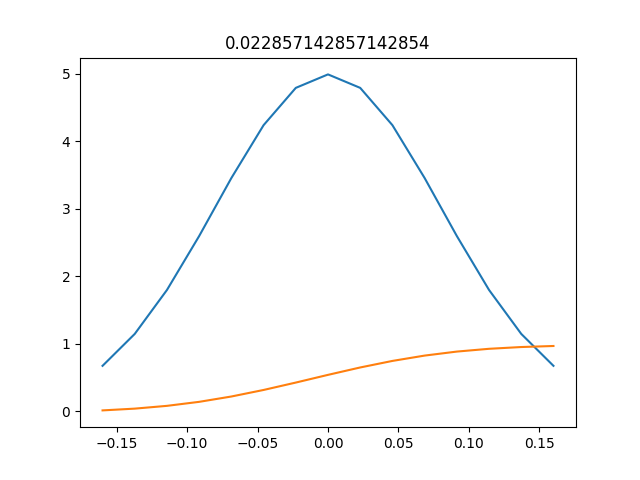

In [5]:
vel_IS_orig = 0.33
vel_S_orig = 2.7
dist_orig = 9.2
std_IS = 0.08
std_t0 = 0.2
std_dist = 2.
std_noise = 0.2

eps_vels_IS = np.linspace(-2*std_IS, 2*std_IS, 15)
eps_t0s = np.linspace(-2*std_t0, 2*std_t0, 10)
eps_dist = np.linspace(-std_dist, std_dist, 5)
depths = np.linspace(0.25, 2., 200)
Mxx = np.linspace(-2, 2, 200)
Mxz = np.linspace(-2, 2, 200)
Mzz = np.linspace(-2, 2, 200)
#Mags = np.linspace(0.1, 1, 20)
proba_eps_vels_IS = (1./(std_IS*np.sqrt(2*np.pi)))*np.exp(-0.5*(eps_vels_IS/std_IS)**2)
proba_eps_t0s = (1./(std_t0*2*np.pi))*np.exp(-0.5*(eps_t0s/std_t0)**2)
proba_eps_dist = (1./(std_dist*np.sqrt(2*np.pi)))*np.exp(-0.5*(eps_dist/std_dist)**2)#np.ones_like(eps_dist)

delta_vel = abs(eps_vels_IS[1]-eps_vels_IS[0])

## MCMC inversion: emcee-based inversion

In [7]:
import emcee

def create_waveform(theta, type_inversion, truths, invert_vel_IS=True, verbose=False):
    
    one_eps_t0, one_eps_dist, one_eps_vel_IS = truths[0], truths[1], truths[2]
    one_Mxx = truths[-4]
    one_Mxz = truths[-3]
    one_Mzz = truths[-2]
    one_depth = truths[-1]
    if type_inversion == 'mt':
        one_Mxx, one_Mxz, one_Mzz = theta
    elif type_inversion == 'loc_mt':
        one_eps_t0, one_eps_dist, one_eps_vel_IS, one_Mxx, one_Mxz, one_Mzz = theta
    elif type_inversion == 'loc_without_vel_mt':
        one_eps_t0, one_eps_dist, one_Mxx, one_Mxz, one_Mzz = theta
    elif type_inversion == 'loc':
        one_eps_t0, one_eps_dist, one_eps_vel_IS = theta
    elif type_inversion == 'loc_without_vel':
        one_eps_t0, one_eps_dist = theta
    elif type_inversion == 'loc_mt_depth':
        one_eps_t0, one_eps_dist, one_eps_vel_IS, one_Mxx, one_Mxz, one_Mzz, one_depth = theta
    elif type_inversion == 'loc_without_vel_mt_depth':
        one_eps_t0, one_eps_dist, one_Mxx, one_Mxz, one_Mzz, one_depth = theta
    elif type_inversion == 'mt_depth':
        one_Mxx, one_Mxz, one_Mzz, one_depth = theta
    
    
    D_T0, D_IS = 0, 0
    if 'loc' in type_inversion:
        eps_time_IS = (dist_orig+one_eps_dist)/(vel_IS_orig + one_eps_vel_IS)-(dist_orig+one_eps_dist)/(vel_IS_orig)
        D_T0 = (one_eps_t0/delta_t).astype(int)
        D_IS = (eps_time_IS/delta_t).astype(int)
    
    #l_depths = [depth for depth in waveforms_S[]]
    #depth = l_depths[0]
    #if 'depth' in type_inversion:
    depth = l_depths[np.argmin(abs(np.array(l_depths)-one_depth))]
    
    l_arrays = {'Mxx': one_Mxx, 'Mxz': one_Mxz, 'Mzz': one_Mzz}
    waveform = np.zeros_like(waveforms_data)
    for mecha in l_mecha:
        waveform[isep:] += l_arrays[mecha]*np.roll(waveforms_IS[mecha][depth], D_IS+D_T0)
        waveform[:isep] += l_arrays[mecha]*waveforms_S[mecha][depth]
        
    if verbose:
        print(f'Producing waveform with parameters:')
        print(f'- depth: {one_depth} km')
        print(f'- eps_distance: {one_eps_dist} km')
        print(f'- eps_velocity: {one_eps_vel_IS} km/s')
        print(f'- eps_t0: {one_eps_t0} s')
        print(f'- Mxx: {one_Mxx}')
        print(f'- Mxz: {one_Mxz}')
        print(f'- Mzz: {one_Mzz}')
        
    return waveform

def compute_one_score(w_S, w_IS, theta, type_inversion, truths):
    waveform = create_waveform(theta, type_inversion, truths)
    score = w_S*(-0.5*np.sum(((waveforms_data[:isep]-waveform[:isep])/std_noise)**2))
    score += w_IS*(-0.5*np.sum(((waveforms_data[isep:]-waveform[isep:])/std_noise)**2))
    return score

def log_likelihood(theta, type_inversion, truths, use_uncertainties=False, w_IS=2.5, w_S=1.):
    
    score = 0
    
    at_least_on_uncertainty = False
    if use_uncertainties:
        
        uncertainty_on_vel_IS, uncertainty_on_loc = False, False
        delta_vel, delta_t0, delta_dist = 1., 1., 1.
        if ('without_vel' in type_inversion) or (not 'loc' in type_inversion):
            at_least_on_uncertainty = True
            l_eps_vel_IS = eps_vels_IS
            l_proba_eps_vels_IS = proba_eps_vels_IS
            uncertainty_on_vel_IS = True
            delta_vel = abs(eps_vels_IS[1]-eps_vels_IS[0])
        else:
            l_eps_vel_IS = [theta[2]]
            l_proba_eps_vels_IS = [1.]
            
        if not 'loc' in type_inversion:
            at_least_on_uncertainty = True
            uncertainty_on_loc = True
            l_eps_t0s = eps_t0s
            l_proba_eps_t0s = proba_eps_t0s
            delta_t0 = abs(eps_t0s[1]-eps_t0s[0])
            l_eps_dist = eps_dist
            l_proba_eps_dist = proba_eps_dist
            delta_dist = abs(eps_dist[1]-eps_dist[0])
            istart += 2
        else:
            l_eps_t0s = [theta[0]]
            l_proba_eps_t0s = [1.]
            l_eps_dist = [theta[1]]
            l_proba_eps_dist = [1.]
     
    if at_least_on_uncertainty:
        type_inversion_loc = 'loc_mt_depth'
        for vel_IS, proba_IS in zip(l_eps_vel_IS, l_proba_eps_vels_IS):
            for t0, proba_t0 in zip(l_eps_t0s, l_proba_eps_t0s):
                for dist, proba_dist in zip(l_eps_dist, l_proba_eps_dist):
                    theta_loc = (t0, dist, vel_IS)
                    if uncertainty_on_loc:
                        istart = 0
                    elif not uncertainty_on_loc:
                        istart = 2
                    for i in theta[istart:]:  
                        theta_loc += (i,)
                    #print(theta_loc)
                    score += delta_vel*delta_t0*delta_dist*proba_IS*proba_t0*proba_dist*compute_one_score(w_S, w_IS, theta_loc, type_inversion_loc, truths)
                
    else:        
        score += compute_one_score(w_S, w_IS, theta, type_inversion, truths)
    
    return score

def log_prior(theta, type_inversion, use_prior):
    
    if type_inversion == 'mt':
        one_Mxx, one_Mxz, one_Mzz = theta
        bool_cond = Mxx.min() <= one_Mxx < Mxx.max() and Mxz.min() <= one_Mxz < Mxz.max() and Mzz.min() <= one_Mzz < Mzz.max()
    
    elif type_inversion == 'loc_mt':
        one_eps_t0, one_eps_dist, one_eps_vel_IS, one_Mxx, one_Mxz, one_Mzz = theta
        bool_cond = eps_t0s.min() <= one_eps_t0 <= eps_t0s.max() and eps_dist.min() <= one_eps_dist < eps_dist.max() and eps_vels_IS.min() <= one_eps_vel_IS < eps_vels_IS.max() and Mxx.min() <= one_Mxx < Mxx.max() and Mxz.min() <= one_Mxz < Mxz.max() and Mzz.min() <= one_Mzz < Mzz.max()
    
    elif type_inversion == 'loc_without_vel_mt':
        one_eps_t0, one_eps_dist, one_Mxx, one_Mxz, one_Mzz = theta
        bool_cond = eps_t0s.min() <= one_eps_t0 <= eps_t0s.max() and eps_dist.min() <= one_eps_dist < eps_dist.max() and Mxx.min() <= one_Mxx < Mxx.max() and Mxz.min() <= one_Mxz < Mxz.max() and Mzz.min() <= one_Mzz < Mzz.max()
    
    elif type_inversion == 'loc':
        one_eps_t0, one_eps_dist, one_eps_vel_IS = theta
        bool_cond = eps_t0s.min() <= one_eps_t0 <= eps_t0s.max() and eps_dist.min() <= one_eps_dist < eps_dist.max() and eps_vels_IS.min() <= one_eps_vel_IS < eps_vels_IS.max()
        
    elif type_inversion == 'loc_mt_depth':
        one_eps_t0, one_eps_dist, one_eps_vel_IS, one_Mxx, one_Mxz, one_Mzz, one_depth = theta
        bool_cond = eps_t0s.min() <= one_eps_t0 <= eps_t0s.max() and eps_dist.min() <= one_eps_dist < eps_dist.max() and eps_vels_IS.min() <= one_eps_vel_IS < eps_vels_IS.max() and Mxx.min() <= one_Mxx < Mxx.max() and Mxz.min() <= one_Mxz < Mxz.max() and Mzz.min() <= one_Mzz < Mzz.max() and depths.min() <= one_depth < depths.max()
    
    elif type_inversion == 'loc_without_vel_mt_depth':
        one_eps_t0, one_eps_dist, one_Mxx, one_Mxz, one_Mzz, one_depth = theta
        bool_cond = eps_t0s.min() <= one_eps_t0 <= eps_t0s.max() and eps_dist.min() <= one_eps_dist < eps_dist.max() and Mxx.min() <= one_Mxx < Mxx.max() and Mxz.min() <= one_Mxz < Mxz.max() and Mzz.min() <= one_Mzz < Mzz.max() and depths.min() <= one_depth < depths.max()
    
    elif type_inversion == 'mt_depth':
        one_Mxx, one_Mxz, one_Mzz, one_depth = theta
        bool_cond = Mxx.min() <= one_Mxx < Mxx.max() and Mxz.min() <= one_Mxz < Mxz.max() and Mzz.min() <= one_Mzz < Mzz.max() and depths.min() <= one_depth < depths.max()
    
    if bool_cond:
         
        proba_IS, proba_t0, proba_dist = 0., 0., 0.
        
        if ('loc' in type_inversion) and use_prior:
            proba_t0 = -(one_eps_t0/std_t0)**2
            proba_dist = -(one_eps_dist/std_dist)**2
            
            if not 'without_vel' in type_inversion:
                proba_IS = -(one_eps_vel_IS/std_IS)**2
            
        return proba_IS + proba_t0 + proba_dist
    
    return -np.inf

def log_probability(theta, type_inversion, use_prior, truths, use_uncertainties=False, w_IS=2.5, w_S=1.):
    lp = log_prior(theta, type_inversion, use_prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, type_inversion, truths, use_uncertainties, w_IS=w_IS, w_S=w_S)

def return_initial_conditions(type_inversion):

    if type_inversion == 'mt':
        pos = np.c_[np.random.choice(Mxx, nwalkers), 
                np.random.choice(Mxz, nwalkers), 
                np.random.choice(Mzz, nwalkers),]
    elif type_inversion == 'loc_mt':
        pos = np.c_[np.random.choice(eps_t0s, nwalkers), 
                np.random.choice(eps_dist, nwalkers), 
                np.random.choice(eps_vels_IS, nwalkers), 
                np.random.choice(Mxx, nwalkers), 
                np.random.choice(Mxz, nwalkers), 
                np.random.choice(Mzz, nwalkers),]
        
    elif type_inversion == 'loc_without_vel_mt':
        pos = np.c_[np.random.choice(eps_t0s, nwalkers), 
                np.random.choice(eps_dist, nwalkers),  
                np.random.choice(Mxx, nwalkers), 
                np.random.choice(Mxz, nwalkers), 
                np.random.choice(Mzz, nwalkers),]
        
    elif type_inversion == 'loc':
        pos = np.c_[np.random.choice(eps_t0s, nwalkers), 
                np.random.choice(eps_dist, nwalkers), 
                np.random.choice(eps_vels_IS, nwalkers)] 

    elif type_inversion == 'loc_mt_depth':
        pos = np.c_[np.random.choice(eps_t0s, nwalkers), 
                np.random.choice(eps_dist, nwalkers), 
                np.random.choice(eps_vels_IS, nwalkers), 
                np.random.choice(Mxx, nwalkers), 
                np.random.choice(Mxz, nwalkers), 
                np.random.choice(Mzz, nwalkers), 
                np.random.choice(depths, nwalkers)]
        
    elif type_inversion == 'loc_without_vel_mt_depth':
        pos = np.c_[np.random.choice(eps_t0s, nwalkers), 
                np.random.choice(eps_dist, nwalkers),  
                np.random.choice(Mxx, nwalkers), 
                np.random.choice(Mxz, nwalkers), 
                np.random.choice(Mzz, nwalkers), 
                np.random.choice(depths, nwalkers)]

    elif type_inversion == 'mt_depth':
        pos = np.c_[np.random.choice(Mxx, nwalkers), 
                np.random.choice(Mxz, nwalkers), 
                np.random.choice(Mzz, nwalkers), 
                np.random.choice(depths, nwalkers)]
    return pos

truths = [-111981142.7/100000000, -22619948.8/100000000, 2460002/100000000, 1.]
type_inversion = 'loc_mt_depth'
use_prior = True
use_uncertainties = False
nwalkers = 32
pos = return_initial_conditions(type_inversion)
ndim = pos.shape[1]
if True:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=([type_inversion, use_prior, truths, use_uncertainties])
    )
    sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:43<00:00, 114.86it/s]


## Figure 3: Plotting distributions

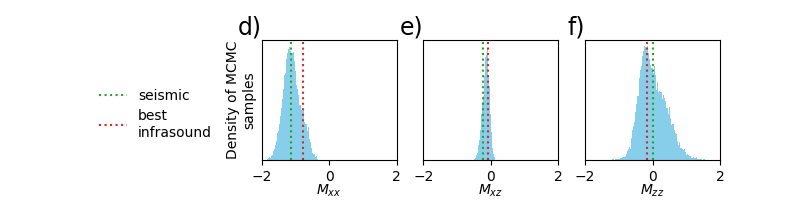

In [51]:
from matplotlib.ticker import FixedLocator
import string

def return_ids(type_inversion):
    
    l_ids = []
    if 'loc' in type_inversion:
        
        if not 'without_vel' in type_inversion:
            l_ids += [0,1,2]
        else:
            l_ids += [0,1]
        
    if 'mt' in type_inversion:
        l_ids += [3,4,5]
    
    if 'depth' in type_inversion:
        l_ids += [6]
        
    return np.array(l_ids)

def return_labels(type_inversion):
    
    labels = ["$\epsilon_{t_0}$ (s)", "$\epsilon_{distance}$ (km)", "$\epsilon_{vel}$ (km/s)", '$M_{xx}$', '$M_{xz}$', '$M_{zz}$', 'Depth (km)']
    return np.array(labels)[return_ids(type_inversion)]

def return_truths(type_inversion):
    
    truths = [0., 0., 0., -111981142.7/100000000, -22619948.8/100000000, 2460002/100000000, 1.]
    return np.array(truths)[return_ids(type_inversion)]

def return_xlims(type_inversion):
    
    xlims = [0.2*2, 2., 0.08*2, 2., 2., 2., 2.]
    return np.array(xlims)[return_ids(type_inversion)]

def plot_distributions(flat_samples, log_flat_samples, labels, xlims, truths, ioffset_alphabet=3, only_unknows=[]):
    
    imin = log_flat_samples.argmax()
    alphabet = string.ascii_lowercase
    
    #fig = plt.figure(figsize=(3,6))
    #grid = fig.add_gridspec(1+flat_samples.shape[1]//2, 2)
    if only_unknows:
        fig = plt.figure(figsize=(8,2))
        n_unknowns = len(only_unknows)
        grid = fig.add_gridspec(1,1+n_unknowns)
    else:
        fig = plt.figure(figsize=(8,3))
        n_unknowns = flat_samples.shape[1]
        grid = fig.add_gridspec(2,1+n_unknowns//2)
    #labels = labels[-flat_samples.shape[1]:]
    #truths = truths[-flat_samples.shape[1]:]
    #xlims = xlims[-flat_samples.shape[1]:]
    icol = 0
    i_row = 0
    for i_iter in range(n_unknowns):
        """
        i_row += 1
        if i_row > 3:
            icol = 1
            i_row = 0
        """
        if only_unknows:
            icol = i_iter+1
            i = only_unknows[i_iter]
        else:
            icol += 1
            if icol > 3:
                i_row = 1
                icol = 0
            i = i_iter
            
        #ax = fig.add_subplot(grid[0, i])
        ax = fig.add_subplot(grid[i_row, icol])
        ax.hist(flat_samples[:,i], bins=100, color='skyblue', density=True)
        ax.set_xlabel(labels[i], labelpad=-1)
        ax.axvline(truths[i], color='tab:green', linestyle=':', label='seismic')
        ax.axvline(flat_samples[imin, i], color='tab:red', linestyle=':', label='best\ninfrasound')
        ax.tick_params(axis='both', which='both', labelleft=False, left=False)
        if 'Depth' in labels[i]:
            ax.set_xlim([0., xlims[i]])
        else:
            ax.set_xlim([-xlims[i], xlims[i]])
            
        if 't_0' in labels[i]:
            #fmt = lambda x, pos: f'{x:.1f}'
            #ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
            ax.xaxis.set_major_locator(FixedLocator([-0.2, 0., 0.2]))
        
        if i_iter == 0:
            ax.legend(frameon=False, ncol=1, bbox_to_anchor=(-1.3, 0.7), loc='upper left')
            ax.set_ylabel('Density of MCMC\nsamples')
            
        ax.text(-0.0, 1.2, alphabet[i_iter+ioffset_alphabet]+')', ha='right', va='top', transform=ax.transAxes, fontsize=17.)
        
    #fig.subplots_adjust(bottom=0.25)
    #fig.subplots_adjust(bottom=0.1, hspace=0.7, top=0.9, left=0.2)
    fig.subplots_adjust(hspace=0.5, bottom=0.2, top=0.8,)
    fig.savefig('./figures/distrib_unknowns_inversion_horizontal_onlymt.pdf')
 
labels = return_labels(type_inversion)
truths = return_truths(type_inversion)
xlims = return_xlims(type_inversion)
opt = dict(discard=200, thin=10, flat=True)
flat_samples = sampler.get_chain(**opt)[:,:]
log_flat_samples = sampler.get_log_prob(**opt)[:]
#pd_flat_samples = pd.read_csv('./inversion/results_Mxz_1km.csv', header=[0])
#flat_samples = pd_flat_samples[['Mxx', 'Mxz', 'Mzz']].values

plot_distributions(flat_samples, log_flat_samples, labels, xlims, truths, only_unknows=[3,4,5])

## Saving results

In [184]:
opt = dict(discard=200, thin=10, flat=True)
flat_samples = sampler.get_chain(**opt)[:,:]
log_flat_samples = sampler.get_log_prob(**opt)[:]
#results_existing = pd.read_csv('./inversion/results_Mxz_1km.csv', header=[0])
results = pd.DataFrame(np.c_[flat_samples, log_flat_samples], columns=['Mxx', 'Mxz', 'Mzz', 'likelihood'])
results['f_min'] = freq_bands[id_freq][0]
results['f_max'] = freq_bands[id_freq][1]
#results_existing = results_existing.append(results)
#results_existing[['Mxx', 'Mxz', 'Mzz', 'f_min', 'f_max']]
results.to_csv('./inversion/results_Mxz_1km.csv', header=True, index=False)

## Plotting inverted moment tensor

[-1.74101437 -0.35835582 -8.47456249  0.21345177 -1.03800915  1.74267288]


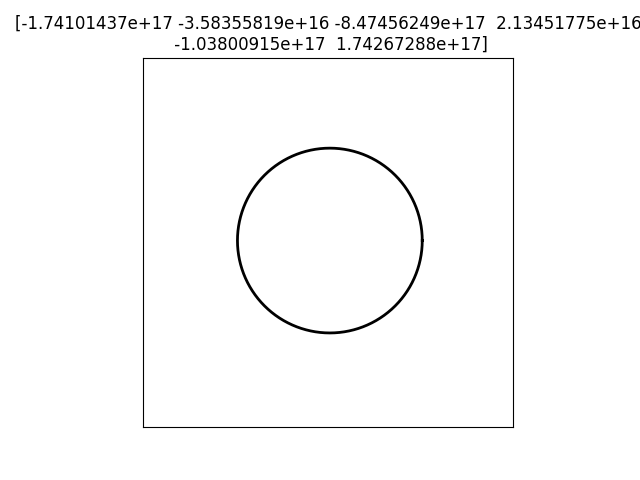

In [10]:
from pyrocko import moment_tensor as pmt
from pyrocko.plot import beachball
from pyproj import Geod
    
def plot_mt(mt):
    #from pyrocko import moment_tensor as mtm
    #mw = 4.6
    #dict_source = {'mnn': 0.039, 'mne': 0.151, 'mnd': -0.613, 'mee': -0.928, 'med': 0.407, 'mdd': 0.889,  } # GCMT
    color_t = 'tab:blue'
    name = 'GCMT'
    plt.figure()
    ax = plt.gca()
    #beachball.plot_beachball_mpl(mt, axes=ax, position=(0.5, 0.5), size=100, beachball_type= 'full')
    beachball.plot_fuzzy_beachball_mpl_pixmap([mt], axes=ax, position=(0.5, 0.5), size=50, beachball_type='full', color_t=color_t, color_p='white', edgecolor='black', linewidth=2)
    plt.title(mt.m6_up_south_east())
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plt.tick_params(axis='both', which='both', labelleft=False, left=False, labelbottom=False, bottom=False)
    
opt = dict(discard=0, thin=10, flat=True)
flat_samples = sampler.get_chain(**opt)[:,:]
log_flat_samples = sampler.get_log_prob(**opt)[:]

def setup_mt(flat_samples, type_inversion, id):

    #id = log_flat_samples.argmax()
    #id = 1
    if 'depth' in type_inversion:
        mee = flat_samples[id,-4] # Mxx
        mue = flat_samples[id,-3] # Mxz
        muu = flat_samples[id,-2] # Mzz  
    else:
        mee = flat_samples[id,-3] # Mxx
        mue = flat_samples[id,-2] # Mxz
        muu = flat_samples[id,-1] # Mzz
    #mee = 1.
    #mue = 0.
    #muu = 0.
    mus = 0.
    mss = 0.
    mse = 0.

    exp = pmt.magnitude_to_moment(6.)  # convert the mag to moment in [Nm]
    opt = dict(
        mdd = muu*exp,
        mnd = mus*exp,
        mnn = mss*exp,
        med = -mue*exp,
        mee = mee*exp,
        mne = -mse*exp)
    mt = pmt.MomentTensor(**opt)

    source_loc = (67.83965, 20.20759)
    station_loc = (67.8560, 20.4201)
    wgs84_geod = Geod(ellps='WGS84')
    az, _, _ = wgs84_geod.inv(source_loc[1], source_loc[0], station_loc[1], station_loc[0])
    mt = mt.rotated(pmt.rotation_from_angle_and_axis(-(90-az), [0,0,1])  )
    
    return mt

mt = setup_mt(flat_samples, type_inversion, log_flat_samples.argmax())
print(mt.m6_up_south_east()/1e17)
plot_mt(mt)

## Figure 3: Waveform plotting 

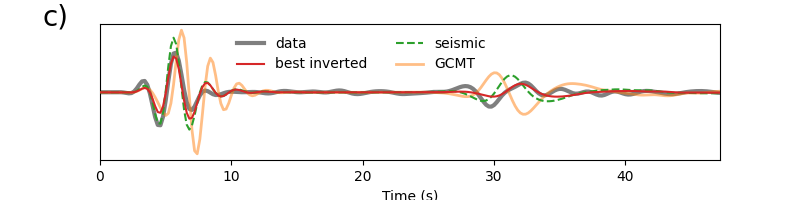

In [43]:
from matplotlib import patheffects
path_effects = [patheffects.withStroke(linewidth=3, foreground="w")]

def create_trace(waveform, sampling_freq):
    
    tr = obspy.Trace()
    tr.data = waveform
    tr.stats.delta = 1./sampling_freq
    return tr

def plot_one_solution(ax, freq_bands, tr_waveform, tr_waveform_data, score, tr_waveform_celso=None, tr_waveform_GCMT=None, tr_waveform_add=[]):
    
    c_data = 'black'
    c_inverted = 'tab:red'
    c_celso = 'tab:green'
    c_GCMT = 'tab:orange'
    
    if tr_waveform_add:
        c_add = sns.color_palette("Paired", n_colors=len(tr_waveform_add))
    
    
    for iband, band in enumerate(freq_bands):
        offset = 2*iband
        tr_waveform_loc = tr_waveform.copy()
        tr_waveform_loc.filter('bandpass', freqmin=band[0], freqmax=band[1])
        tr_waveform_data_loc = tr_waveform_data.copy()
        tr_waveform_data_loc.filter('bandpass', freqmin=band[0], freqmax=band[1])
        if tr_waveform_celso is not None:
            tr_waveform_celso_loc = tr_waveform_celso.copy()
            tr_waveform_celso_loc.filter('bandpass', freqmin=band[0], freqmax=band[1])
        if tr_waveform_GCMT is not None:
            tr_waveform_GCMT_loc = tr_waveform_GCMT.copy()
            tr_waveform_GCMT_loc.filter('bandpass', freqmin=band[0], freqmax=band[1])
        if tr_waveform_add:
            tr_waveform_add_loc = []
            for tr in tr_waveform_add:
                tr_waveform_add_loc.append( tr.copy() )
                tr_waveform_add_loc[-1].filter('bandpass', freqmin=band[0], freqmax=band[1])
            
        caption_data, caption_inverted, caption_celso, caption_GCMT, caption_add = dict(), dict(), dict(), dict(), dict()
        if iband == 0:
            caption_data, caption_inverted, caption_celso, caption_GCMT = dict(label='data'), dict(label='best inverted'), dict(label='seismic'), dict(label='GCMT')
        
        ax.plot(tr_waveform_data_loc.times(), offset+tr_waveform_data_loc.data/abs(tr_waveform_data_loc.data).max(), color=c_data, linewidth=3, alpha=0.5, **caption_data, zorder=1)
        ax.plot(tr_waveform_loc.times(), offset+tr_waveform_loc.data/abs(tr_waveform_data_loc.data).max(), color=c_inverted, **caption_inverted, zorder=20)
        if tr_waveform_celso is not None:
            ax.plot(tr_waveform_celso_loc.times(), offset+tr_waveform_celso_loc.data/abs(tr_waveform_data_loc.data).max(), color=c_celso, linestyle='--', **caption_celso, zorder=15)
        if tr_waveform_GCMT is not None:
            ax.plot(tr_waveform_GCMT_loc.times(), offset+tr_waveform_GCMT_loc.data/abs(tr_waveform_data_loc.data).max(), color=c_GCMT, linestyle='-', linewidth=2., alpha=0.5, **caption_GCMT, zorder=10)
        if tr_waveform_add:
            for itr, tr in enumerate(tr_waveform_add_loc):
                if iband == 0:
                    caption_add = dict(label=tr.stats.station)
                else:
                    caption_add = dict()
                ax.plot(tr.times(), offset+tr.data/abs(tr_waveform_data_loc.data).max(), linestyle='-', color=c_add[itr], linewidth=2., alpha=1., **caption_add, zorder=1000)
        #ax.text(tr_waveform_loc.times()[-1], offset, f'{band[0]}     \n{band[1]} Hz', ha='right', path_effects=path_effects)

    ax.tick_params(axis='both', which='both', labelleft=False, left=False)
    
    ax.legend(frameon=False, ncol=2, bbox_to_anchor=(0.2, 1.), loc='upper left')
    #ax.set_title(f'Score: {np.exp(score):.2e}')
    #ax.legend(frameon=False)
    ax.set_xlabel('Time (s)')
    ax.set_xlim([0., tr_waveform.times().max()])
    

def plot_waveforms(flat_samples, log_flat_samples, waveforms_data, sampling_freq, type_inversion, truths=None, depth_additional=[], truths_GCMT=None, id_random=0, freq_bands=[(0.05, 0.3), (0.2, 0.5), (0.05, 0.5)]):

    tr_waveform_data = create_trace(waveforms_data, sampling_freq)
    
    if id_random > 0:
        nplots = 2
        fig = plt.figure(figsize=(12,3))
    else:
        nplots = 1
        fig = plt.figure(figsize=(8,2))
    grid = fig.add_gridspec(1, nplots)
    
    imin = log_flat_samples.argmax()
    #imin = -1
    inverted_best = flat_samples[imin,:]
    waveform = create_waveform(inverted_best, type_inversion, truths)
    tr_waveform = create_trace(waveform, sampling_freq)
    
    tr_waveform_add = []
    if depth_additional:
        for zs in depth_additional:
            inds = np.where(abs(flat_samples[:,-1]-zs) < 0.2)[0]
            imin = log_flat_samples[inds].argmax()
            inverted_best = flat_samples[inds[imin],:]
            waveform_add = create_waveform(inverted_best, type_inversion, truths, verbose=False)
            tr_waveform_add.append( create_trace(waveform_add, sampling_freq) )
            tr_waveform_add[-1].stats.station = f'$z_s={zs}$ km'
    
    tr_waveform_celso = None
    if (truths is not None) and len(depth_additional) == 0:
        waveform_celso = create_waveform(np.array(truths)[return_ids(type_inversion)], type_inversion, truths, verbose=False)
        tr_waveform_celso = create_trace(waveform_celso, sampling_freq)
        
    tr_waveform_GCMT = None
    if truths_GCMT is not None:
        waveform_GCMT = create_waveform(np.array(truths_GCMT)[return_ids(type_inversion)], type_inversion, truths_GCMT, verbose=False)
        tr_waveform_GCMT = create_trace(waveform_GCMT, sampling_freq)
    
    ax = fig.add_subplot(grid[0, 0])
    plot_one_solution(ax, freq_bands, tr_waveform, tr_waveform_data, log_likelihood(flat_samples[imin,:], type_inversion, truths), tr_waveform_celso=tr_waveform_celso, tr_waveform_GCMT=tr_waveform_GCMT, tr_waveform_add=tr_waveform_add)

    if id_random > 0:
        waveform = create_waveform(flat_samples[id_random,:], type_inversion, truths)
        tr_waveform = create_trace(waveform, sampling_freq)
        ax = fig.add_subplot(grid[0, 1])
        plot_one_solution(ax, freq_bands, tr_waveform, tr_waveform_data, log_likelihood(flat_samples[id_random,:], type_inversion, truths), tr_waveform_celso=tr_waveform_celso, tr_waveform_add=tr_waveform_add)
    
    ax.text(-0.05, 1.15, 'c)', ha='right', va='top', transform=ax.transAxes, fontsize=20.)
    fig.subplots_adjust(bottom=0.2)
    fig.savefig('./figures/inverted_local_data_onefreq.pdf')
    
#truths = [0., 0., 0., -111981142.7/100000000, -22619948.8/100000000, 2460002/100000000, 1.]
truths = [0., 0., 0., -111981142.7/100000000, -22619948.8/100000000, 2460002/100000000, 1.]
truths_GCMT = [0., 0., 0., -79047750.4417068/100000000, 79232208.40008985/100000000, -30468991.768076744/100000000, 1.] 
#truths = [-111981142.7/100000000, -22619948.8/100000000, 2460002/100000000, 1.]
opt = dict(discard=0, thin=10, flat=True)
flat_samples = sampler.get_chain(**opt)[:,:]
log_flat_samples = sampler.get_log_prob(**opt)[:]
plot_waveforms(flat_samples, log_flat_samples, waveforms_data, freq, type_inversion, truths=truths, depth_additional=[], truths_GCMT=truths_GCMT, id_random=-1, freq_bands=[(0.05, 0.5)])
#plot_waveforms(flat_samples, log_flat_samples, waveforms_data, freq, type_inversion, truths=truths, depth_additional=[0.5, 2.], truths_GCMT=None, id_random=-1, freq_bands=[(0.05, 0.5)])

## Supp Figure: Plotting seismo-acoustic misfit ratio

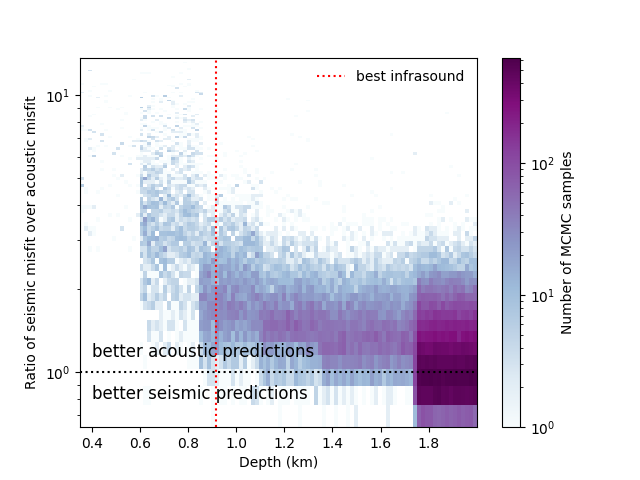

In [668]:
from matplotlib import colors
from tqdm import tqdm
norm = colors.LogNorm()

def compute_one_score_IS_S(theta, type_inversion, truths):
    waveform = create_waveform(theta, type_inversion, truths)
    score_S  = (-0.5*np.sum(((waveforms_data[:isep]-waveform[:isep])/std_noise)**2))
    score_IS = (-0.5*np.sum(((waveforms_data[isep:]-waveform[isep:])/std_noise)**2))
    return score_S, score_IS

compute_scores = False
if compute_scores:
    w_S, w_IS = 1., 2.5
    log_flat_samples_S, log_flat_samples_IS = [], []
    for i in tqdm(range(flat_samples.shape[0])):
        S, IS = compute_one_score_IS_S(flat_samples[i,:], type_inversion, truths)
        log_flat_samples_S.append(S)
        log_flat_samples_IS.append(IS)

log_flat_samples_IS, log_flat_samples_S = np.array(log_flat_samples_IS), np.array(log_flat_samples_S)
threshold = -30
inds = (log_flat_samples_S > threshold) & (log_flat_samples_IS > threshold)
plt.figure()
_=plt.hist2d(flat_samples[inds,-1], log_flat_samples_S[inds]/log_flat_samples_IS[inds], bins=(100, 100), cmap=plt.cm.BuPu, norm=norm)
plt.axvline(flat_samples[log_flat_samples.argmax(),-1], color='red', linestyle=':', label='best infrasound')
plt.axhline(1., color='black', linestyle=':')
plt.text(0.4, 1.+0.1, 'better acoustic predictions', ha='left', va='bottom', fontsize=12.)
plt.text(0.4, 1.-0.1, 'better seismic predictions', ha='left', va='top', fontsize=12.)
plt.ylabel('Ratio of seismic misfit over acoustic misfit')
plt.xlabel('Depth (km)')
plt.legend(frameon=False)
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Number of MCMC samples')
plt.savefig('./figures/ratio_misfit_solutions.pdf')

## Supp Figure: Plotting corner plot of all MCMC samples

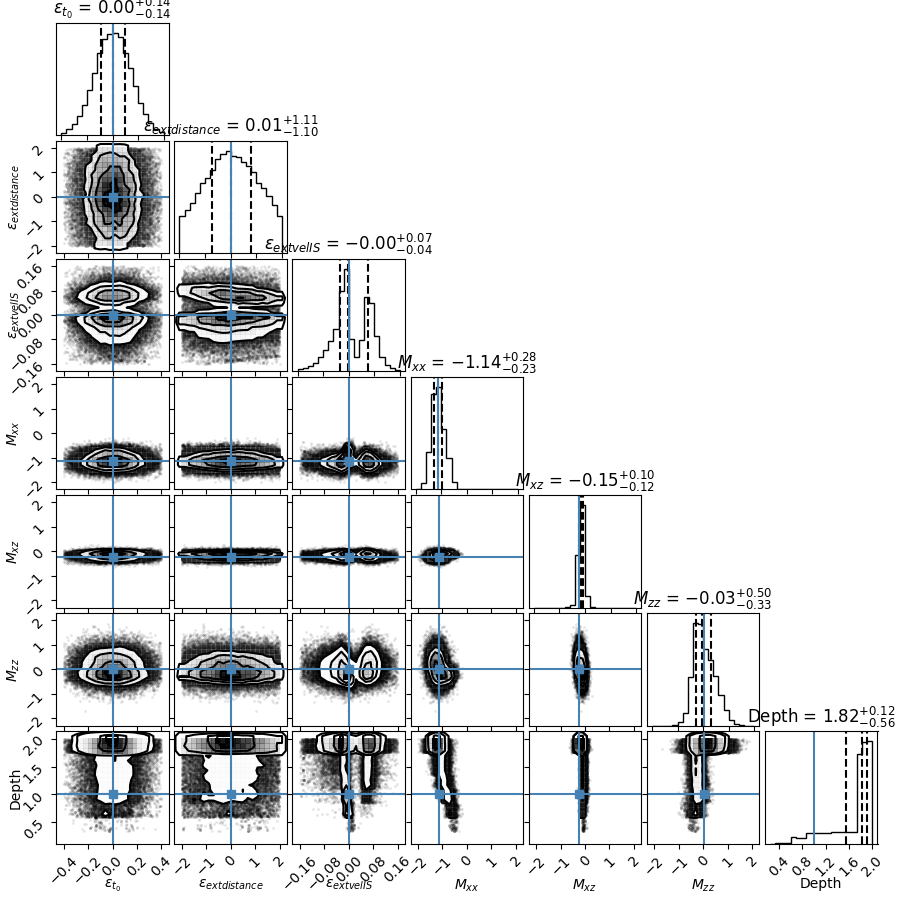

In [606]:
import corner

flat_samples = sampler.get_chain(discard=200, thin=10, flat=True)[:,:]

labels = ["$\epsilon_{t_0}$", "$\epsilon_{\text{distance}}$", "$\epsilon_{\text{vel IS}}$", '$M_{xx}$', '$M_{xz}$', '$M_{zz}$', 'Depth']
labels = ["$\epsilon_{t_0}$", "$\epsilon_{\text{distance}}$", "$\epsilon_{\text{vel IS}}$", '$M_{xx}$', '$M_{xz}$', '$M_{zz}$', 'Depth']

fig = plt.figure(figsize=(9,9))
corner.corner(
    flat_samples, labels=labels, 
    quantiles=[0.25, 0.5, 0.75],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=[0., 0., 0., -111981142.7/100000000, -22619948.8/100000000, 2460002/100000000, 1.], 
    #range = [(eps_t0s.min(), eps_t0s.max()), 
    #         (eps_vels_IS.min(), eps_vels_IS.max()), 
    #         (eps_dist.min(), eps_dist.max()), 
    #         (Mxx.min(), Mxx.max()), 
    #         (Mxz.min(), Mxz.max()), 
    #         (Mzz.min(), Mzz.max())] 
    range = [(eps_t0s.min(), eps_t0s.max()), 
             (eps_dist.min(), eps_dist.max()), 
             (eps_vels_IS.min(), eps_vels_IS.max()), 
             (Mxx.min(), Mxx.max()), 
             (Mxz.min(), Mxz.max()), 
             (Mzz.min(), Mzz.max()), 
             (depths.min(), depths.max())],
    fig = fig
);

# Extract the axes
plot_chain=False
if plot_chain:
    id_chain = 10
    flat_samples = sampler.get_chain(discard=100, thin=10) #(90, 32, 3)
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for yi in range(axes.shape[0]):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.plot(flat_samples[:,id_chain,xi], flat_samples[:,id_chain,yi], color='red', linewidth=0.5)
            
plt.savefig('./figures/distributions_best_inversion.pdf')